TokaMaker Meshing Example: Building a dipole mesh {#doc_tMaker_dipole_ex1}
==========
In this example we show how to generate a mesh for simple levitated dipole using TokaMaker's built in mesh generation.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python packages, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a simple internal python wrapper within OFT.

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain, save_gs_mesh

# Build mesh

## Set mesh resolution for each region
First we define some target sizes to set the resolution in out grid. These variables will be used later and represent the target edge size within a given region, where units are in meters.

**Note:** When setting up a new machine these values will need to scale with the overall size of the device/domain. Additionally, one should perform a convergence study, by increasing resolution (decreasing target size) by at least a factor of two in all regions to ensure the results are not sensitive to your choice of grid size.

In [3]:
plasma_dx = 0.03
coil_dx = 0.02
vv_dx = 0.02
vac_dx = 0.06

## Define regions and attributes
We now create and define the various logical mesh regions. In the dipole case we have 4 region groups:
 - `air`: The region outside the vacuum vessel
 - `plasma`: The region inside the limiter (vacuum vessel) where the plasma will exist
 - `vv`: The vacuum vessel
 - `vacuum`: The vacuum region inside the levitated coil cryostat
 - `dipole, lev`: The Dipole and levitation coils

For each region you can provide a target size and one of four region types:
 - `plasma`: The region where the plasma can exist and the classic Grad-Shafranov equation with $F*F'$ and $P'$ are allowed. **There can only be one region of this type**
 - `vacuum`: A region where no current can flow and $\nabla^* \psi = 0$ is solved
 - `boundary`: A special case of the `vacuum` region, which forms the outer boundary of the computational domain. **A region of this type is required if more than one region is specified**
 - `conductor`: A region where toroidal current can flow passively (no externally applied voltage). For this type of region the resistivity should be specified with the argument `eta` in units of $\omega \mathrm{-m}$.
 - `coil`: A region where toroidal current can flow with specified amplitude through \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_currents "set_coil_currents()" or via shape optimization \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_reg "set_coil_reg()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_isoflux "set_isoflux()"

**Note:** For a dipole we also we the `inner_limiter` argument to true for the vacuum region to mark it as the inner limiter.

In [4]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')                      # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')                  # Define the plasma region and resolution
gs_mesh.define_region('vacuum',plasma_dx,'vacuum',inner_limiter=True)  # Define the vacuum inside the VV
gs_mesh.define_region('vv',vv_dx,'conductor',eta=1.E-5)             # Define the VV

gs_mesh.define_region('dipole',coil_dx,'coil',nTurns=100.0)
gs_mesh.define_region('lev',coil_dx,'coil',nTurns=100.0)

## Define geometry for region boundaries
Once the region types and properties are defined we now define the geometry of the mesh using shapes and references to the defined regions.
 1. The vacuum vessel is added as a "polygon" with curves defining the inner and outer edges respectively.
 2. As the VV goes all the way to the geometric axis we need to define the boundary region explicitly so that the intersection points are present in both the VV and boundary contours.
 3. The inner coil case/limiter is defined as a simple circular path
 4. The plasma region is defined by marking a location in this region
 5. The dipole and levitation coils are defined as simple rectangles

In [5]:
inner_rad = 0.6
outer_rad = 0.62

# Define outer boundary path with points at the VV intersection
boundary_path = np.array([
    [0.0,inner_rad],
    [0.0,outer_rad],
    [0.0,1.5],
    [2.0,1.5],
    [2.0,-1.5],
    [0.0,-1.5],
    [0.0,-outer_rad],
    [0.0,-inner_rad]
])
gs_mesh.add_polygon(boundary_path,'air')

# Define VV geometry
theta = np.linspace(-np.pi/2.0,np.pi/2.0,100)
vv_inner = np.vstack((
    [[0.0,-inner_rad],],
    np.vstack((
        inner_rad*np.cos(theta)+0.5,
        inner_rad*np.sin(theta),
    )).transpose(),
    [[0.0,inner_rad],]
))
vv_outer = np.vstack((
    [[0.0,outer_rad],],
    np.vstack((
        outer_rad*np.cos(np.flip(theta))+0.5,
        outer_rad*np.sin(np.flip(theta)),
    )).transpose(),
    [[0.0,-outer_rad],]
))
gs_mesh.add_polygon(np.vstack((vv_inner,vv_outer)),'vv',parent_name='air')

# Define inner coil case
theta = np.linspace(0.0,2.0*np.pi,100,endpoint=False)
dipole_case = np.vstack((
    0.075*np.cos(theta)+0.3,
    0.075*np.sin(theta),
)).transpose()
gs_mesh.add_polygon(dipole_case,'vacuum',parent_name='plasma')

# Define remaining regions
gs_mesh.add_enclosed([0.7,0.0],'plasma')
gs_mesh.add_rectangle(0.3,0.0,0.05,0.05,'dipole',parent_name='vacuum')
gs_mesh.add_rectangle(0.3,0.75,0.2,0.05,'lev',parent_name='air')

## Plot topology
After defining the logical and physical topology we can now plot the curves within the definitions to double check everything is in the right place.

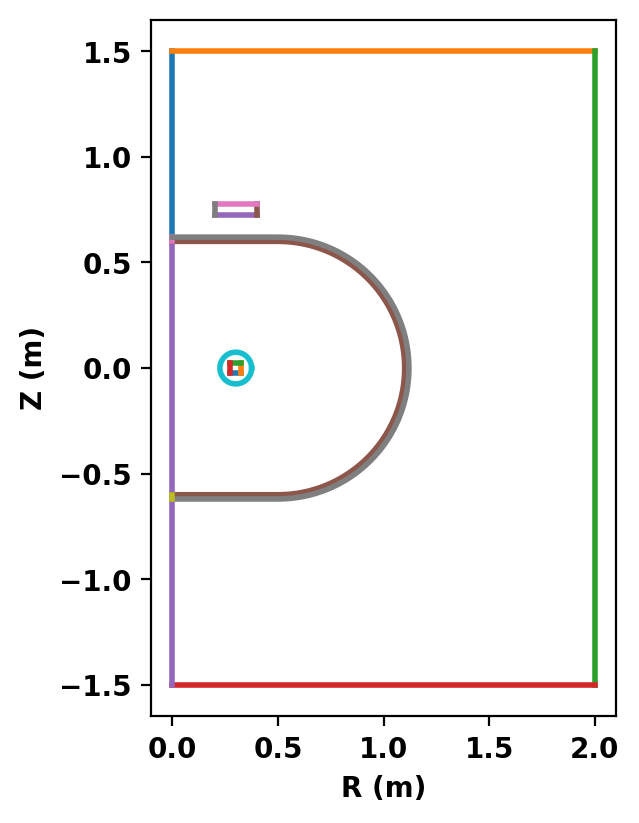

In [6]:
fig, ax = plt.subplots(1,1,figsize=(4,4),constrained_layout=True)
gs_mesh.plot_topology(fig,ax)

## Create mesh
Now we generate the actual mesh using the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.build_mesh "build_mesh()" method. Additionally, if `coil` and/or `conductor` regions are defined the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.get_coils "get_coils()" and \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.get_conductors "get_conductors()" methods should also be called to get descriptive dictionaries for later use in TokaMaker. This step may take a few moments as [triangle](https://www.cs.cmu.edu/~quake/triangle.html) generates the mesh.

Note that, as is common with unstructured meshes, the mesh is stored a list of points `mesh_pts` of size (np,2), a list of cells formed from three points each `mesh_lc` of size (nc,3), and an array providing a region id number for each cell `mesh_reg` of size (nc,), which is mapped to the names above using the `coil_dict` and `cond_dict` dictionaries.

In [7]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 502
  # of unique segments  = 19
Generating mesh:
  # of points  = 4582
  # of cells   = 8976
  # of regions = 6


## Plot resulting regions and grid
We now plot the mesh by region to inspect proper generation.

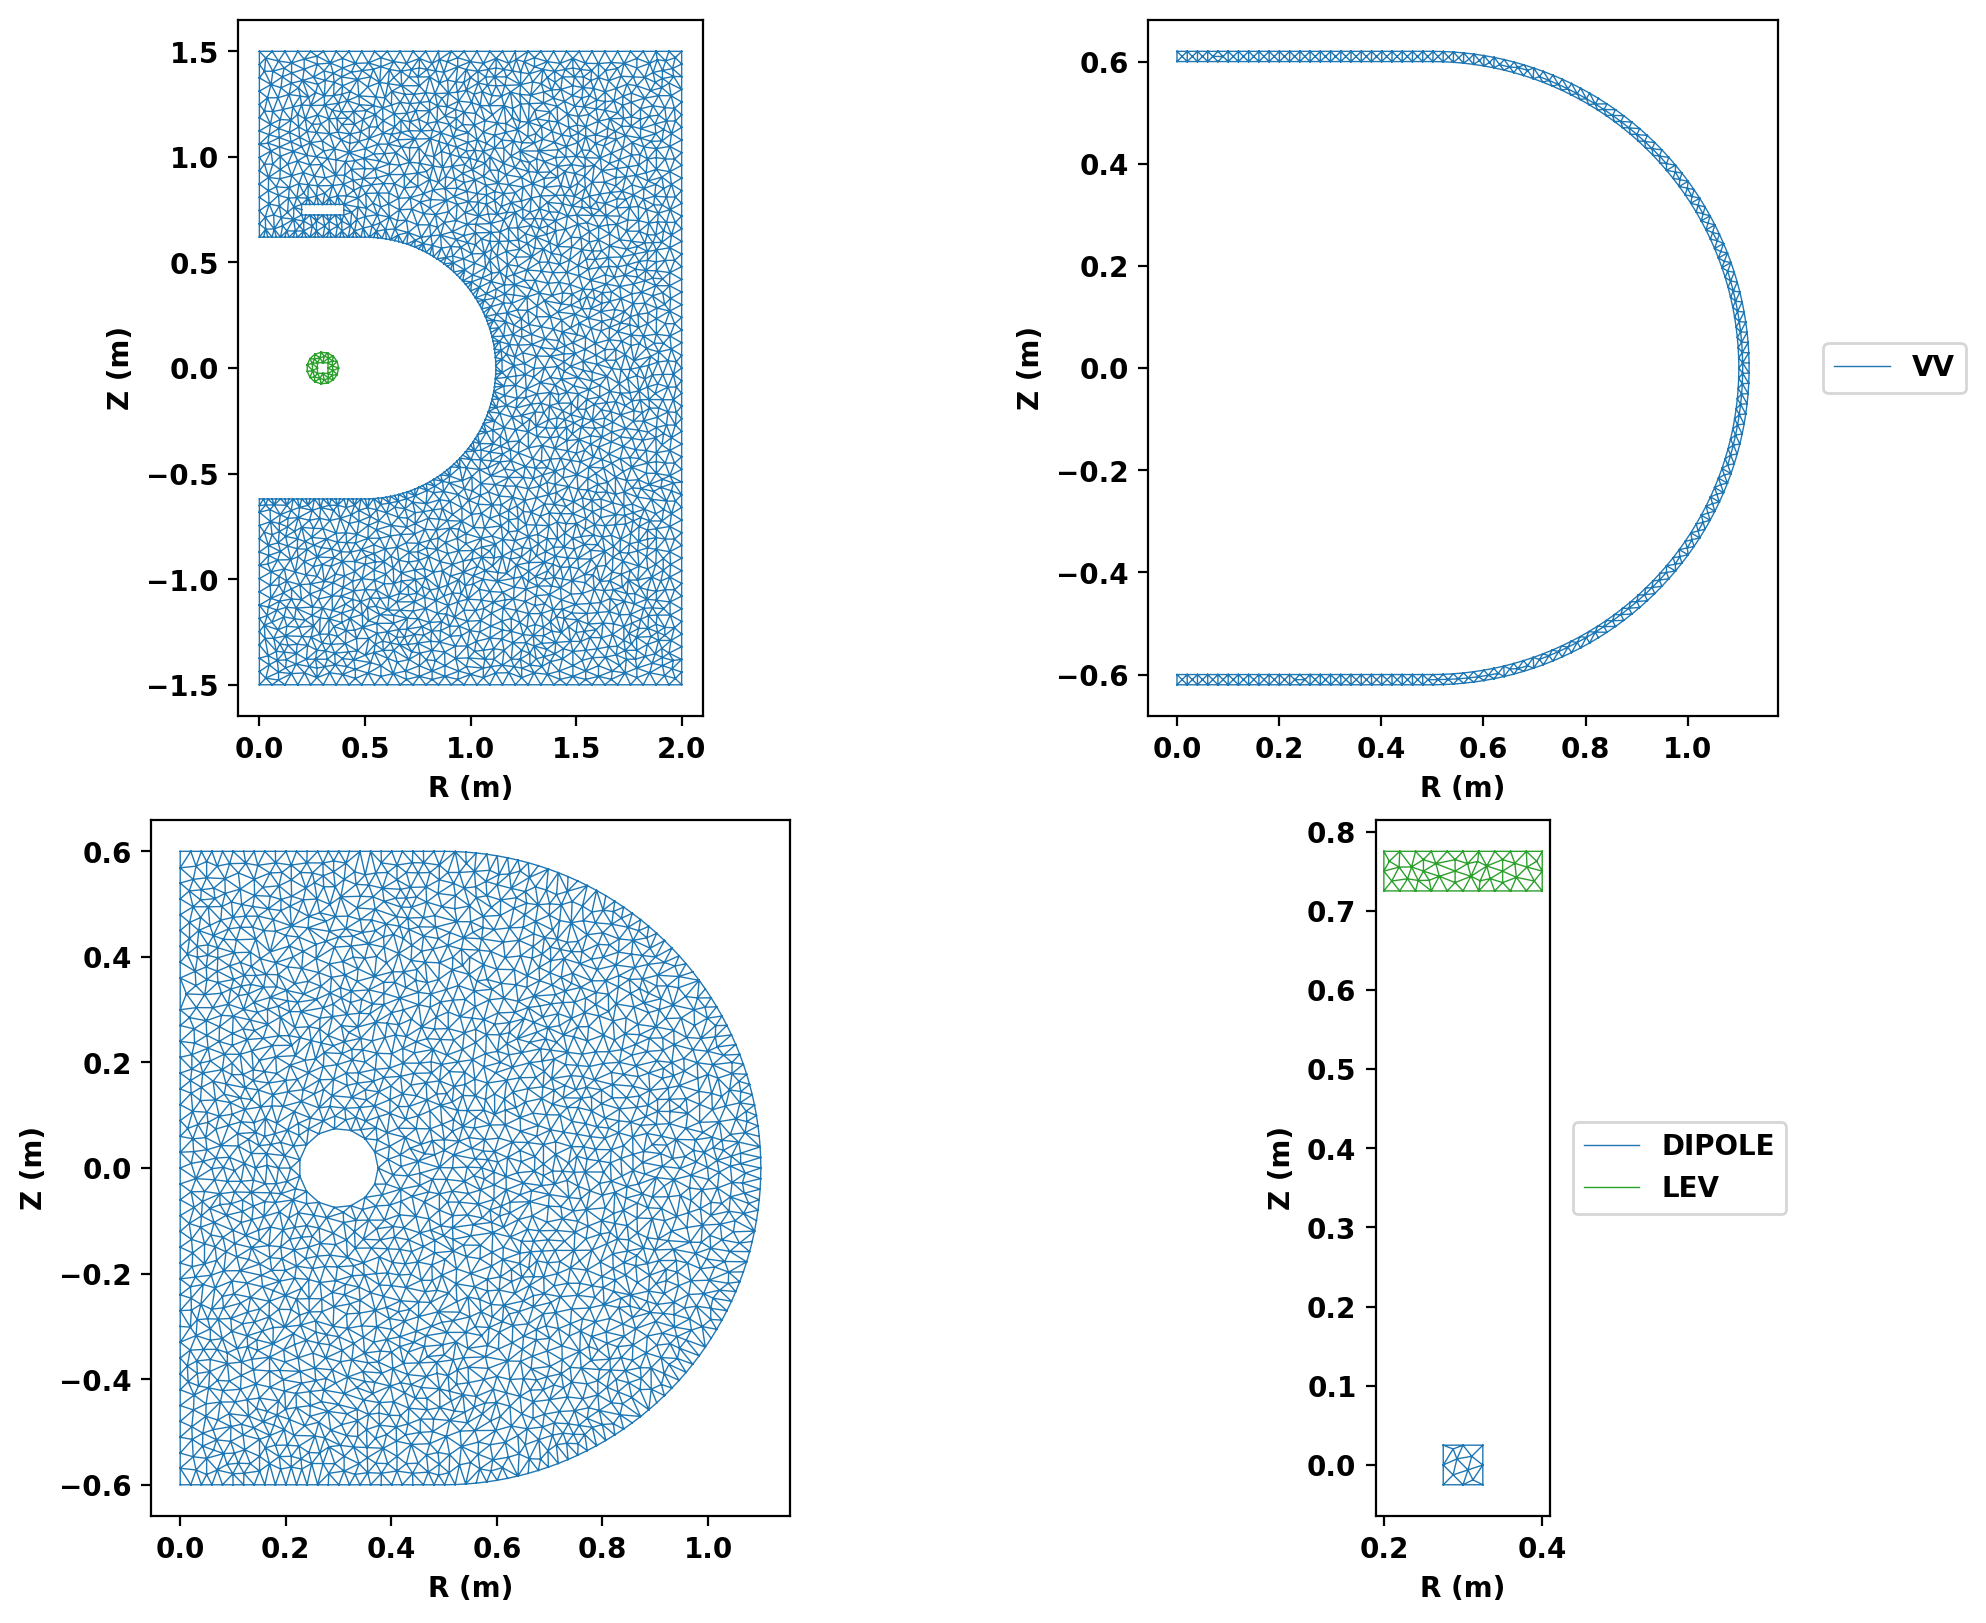

In [8]:
fig, ax = plt.subplots(2,2,figsize=(10,8),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

## Save mesh for later use
As generation of the mesh often takes comparable, or longer, time compare to runs in TokaMaker it is useful to separate generation of the mesh into a different script as demonstrated here. The method \ref OpenFUSIONToolkit.TokaMaker.save_gs_mesh "save_gs_mesh()" can be used to save the resulting information for later use. This is done using and an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) file through the [h5py](https://www.h5py.org/) library.

In [9]:
save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,'dipole_mesh.h5')